## Project 1: Cars vs Bike Dataset, Can Supervised Learning Help differentiate the Two?

#### Data and Purpose

I will be using the Cars vs Bikes Classification dataset on Kaggle. It has two folders, each with 2000 images of cars and bikes. That will be the training set, I will use photos of cars and bikes from my phone: some are mine and some I repaired in the shop. Hopefully I can use LinearSVC to classify the photos.

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
from skimage import io, transform, exposure, filters, feature, color, data
from PIL import Image,ImageOps
from sklearn.model_selection import train_test_split
import random

this is all the normal stuff you would expect for supervised learning

In [5]:
def imNormalize(image):
    if len(image.shape)==2:
        r = image
        g = image
        b = image
    else:
        r = image[:,:,0]
        g = image[:,:,1]
        b = image[:,:,2]
    
    r = r - r.min()
    r = r / r.max()
    r = np.uint8(r * 255)
    
    g = g - g.min()
    g = g / g.max()
    g = np.uint8(g * 255)
    
    b = b - b.min()
    b = b / b.max()
    b = np.uint8(b * 255)
    
    return np.stack((r,g,b),axis=2) 


def colorHistogram(image):
    #image = imNormalize(image)
    image = color.rgb2hsv(image)
    
    h1 = exposure.histogram(image[:,:,0])
    h2 = exposure.histogram(image[:,:,1])
    h3 = exposure.histogram(image[:,:,2])
    h = np.concatenate((h1[0],h2[0],h3[0]), axis = None)
    h = h / (image.shape[0]*image.shape[1])
    return np.array(h)

adding imNormalize and colorHistorgram

In [93]:
path1 = "Car-Bike-Dataset"
path2 = "myphotos"
myclasses = os.listdir(path1)
myclasses

['Bike', 'Car']

making sure that only two classes show up, I'm using old code from the caltech examples so some might be redundant. I'm sure, given more time, I could optimize it for this usecase.

In [177]:
#uses the data set to train the algorithm
traindata = []
trainlabels = []
trainfilenames = []
testdata = []
testlabels = []
testfilenames = []

path1 = "Car-Bike-Dataset"
myclasses = os.listdir(path1)
for classnum in range(len(myclasses)):
    folder = path1 + '/' + myclasses[classnum]
    filelist = os.listdir(folder)
    for i in range(len(filelist)):
        filename = folder + '/' + filelist[i]
        image = io.imread(filename)
        image = imNormalize(image)
        image = transform.resize(image,[256,256])
        fd1 = feature.hog(image, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=False)
        fd2 = colorHistogram(image)
        fd = np.concatenate([fd1, fd2])
        traindata.append(fd)
        trainlabels.append(classnum)
        trainfilenames.append(filename)
        print(i+1, end='\r')
    print("\b")

path2 = "myphotos"
myclasses = os.listdir(path2)
for classnum in range(len(myclasses)):
    folder = path2 + '/' + myclasses[classnum]
    filelist = os.listdir(folder)
    np.random.shuffle(filelist)
    for i in range(len(filelist)):
        filename = folder + '/' + filelist[i]
        image = io.imread(filename)
        image = imNormalize(image)
        image = transform.resize(image,[256,256])
        fd1 = feature.hog(image, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=False)
        fd2 = colorHistogram(image)
        fd = np.concatenate([fd1, fd2])
        testdata.append(fd)
        testlabels.append(classnum)
        testfilenames.append(filename)
        print(i+1, end='\r')
    print("\b")
    

testdata = np.array(testdata)
testlabels = np.array(testlabels)
testfilenames = np.array(testfilenames)
traindata = np.array(traindata)
trainlabels = np.array(trainlabels)
trainfilenames = np.array(trainfilenames)

1794
1937
18
9


Using code given to us in the examples from Moodle. I changed the numtrain to fit the new data size. I'm doing two runs, the first will use only the dataset from kaggle, both to train and to test (different parts of the dataset, obviously)

In [208]:
from sklearn.svm import LinearSVC, SVC
from sklearn .linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier

model1 = SVC()
model1.fit(traindata,trainlabels)
guessedlabels1 = model1.predict(testdata)

model2 = LinearSVC()
model2.fit(traindata,trainlabels)
guessedlabels2 = model2.predict(testdata)

C:\Users\Ethan\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


gonna use both SVC and LinearSVC to see which one is more accurate

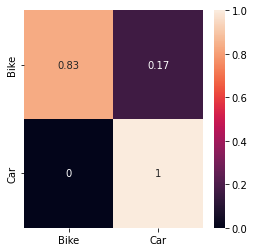

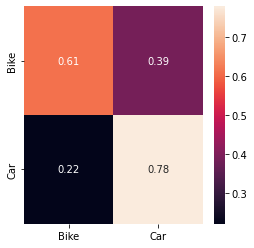

In [210]:
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix

def confusionMatrix(guess_label):
    numClasses = len(myclasses)

    conf = np.zeros([numClasses,numClasses])

    for image in range(len(testlabels)):
        real = testlabels[image]
        guess = guess_label[image]
        conf[real,guess] = conf[real,guess] + 1

    rowsums = np.sum(conf,1)
    rowsums = np.reshape(rowsums,[numClasses,1])
    rowsums = np.repeat(rowsums,numClasses, axis = 1)
    conf = conf / rowsums
    df_cm = pd.DataFrame(conf, index = [i for i in myclasses],
                      columns = [i for i in myclasses])
    plt.figure(figsize = (4,4))
    sn.heatmap(df_cm, annot=True)

confusionMatrix(guessedlabels1)
confusionMatrix(guessedlabels2)

yep, as we see here , regular SVC is more accurate, I'm not too sure why, I don't understand the specifics between the two. But hey, the results are good.

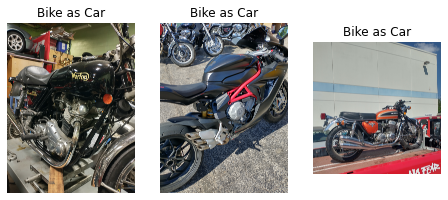

In [184]:
#Visualize wrong results
rows = 2
cols = 6
wrong = np.not_equal(guessedlabels1,testlabels)
fig = plt.figure(figsize=(16, 16))
count = 0
for index in range(len(wrong)):
    if wrong[index]:
        count = count +1
        image = io.imread(testfilenames[index])
        temp = fig.add_subplot(rows, cols ,count)
        temp.imshow(image)
        temp.axis('off')
        temp.title.set_text(myclasses[testlabels[index]]+' as '+myclasses[guessedlabels1[index]])
    if count==rows*cols:
        break
plt.show()

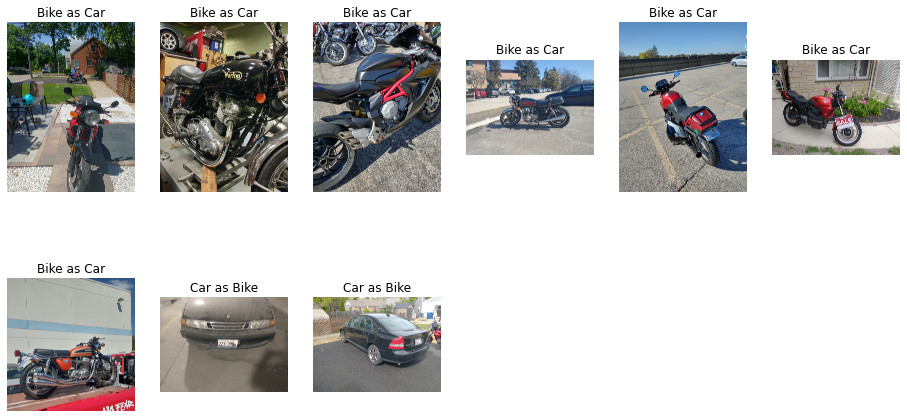

In [186]:
#Visualize wrong results
rows = 2
cols = 6
wrong = np.not_equal(guessedlabels2,testlabels)
fig = plt.figure(figsize=(16, 8))
count = 0
for index in range(len(wrong)):
    if wrong[index]:
        count = count +1
        image = io.imread(testfilenames[index])
        temp = fig.add_subplot(rows, cols ,count)
        temp.imshow(image)
        temp.axis('off')
        temp.title.set_text(myclasses[testlabels[index]]+' as '+myclasses[guessedlabels2[index]])
    if count==rows*cols:
        break
plt.show()

checking the incorrect results for both models